In [ ]:
!pip install transformers sentencepiece
!pip install datasets
!pip install transformers[torch]
!pip install accelerate -U
!pip install --upgrade accelerate
!pip install evaluate
!pip install rouge_score


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 49.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━

In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
import torch

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
tokenizer = T5Tokenizer.from_pretrained("google/mt5-small")
model = T5ForConditionalGeneration.from_pretrained('google/mt5-small')
tokenizer,model

You are using a model of type mt5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.


pytorch_model.bin:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

(T5Tokenizer(name_or_path='google/mt5-small', vocab_size=250100, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
 	0: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	1: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	2: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 },
 T5ForConditionalGeneration(
   (shared): Embedding(250112, 512)
   (encoder): T5Stack(
     (embed_tokens): Embedding(250112, 512)
     (block): ModuleList(
       (0): T5Block(
         (layer): ModuleList(
           (0): T5LayerSelfAttention(
             (SelfAttention): T5Attention(
               (q): Linear(in_features=512, out_features=384, bias=False)

more than half of the size is used by embeddings


In [ ]:

print("tokenizer.vocab_size = ", tokenizer.vocab_size)
def msize(m):
    return sum(p.numel() for p in m.parameters())
print("model size = ",msize(model))
original_size = msize(model)
print("shared params = ",msize(model.shared)) ## token vocabulary is shared
print('encoder = ',msize(model.encoder), " encoder block = ",msize(model.encoder.block))
print('decoder = ',msize(model.decoder), " decoder block = ",msize(model.decoder.block))
print("lm head = " , msize(model.lm_head))
print("lm size / model size = ",msize(model.lm_head) / msize(model))
print(msize(model.shared) / msize(model))  ## token vocabulary is shared


tokenizer.vocab_size =  250100
model size =  300176768
shared params =  128057344
encoder =  146940608  encoder block =  18882752
decoder =  153236160  decoder block =  25178304
lm head =  128057344
lm size / model size =  0.4266064454395085
0.4266064454395085


read the csv file

In [ ]:
import pandas as pd
pd.options.display.max_colwidth = 300
import csv

df_fr_tr = pd.read_csv('./data/train.csv',header=None, skiprows=1)
df_fr_va = pd.read_csv('./data/validation.csv',header=None, skiprows=1)
df_fr_te = pd.read_csv('./data/test_text.csv',header=None, skiprows=1)
df_fr_tr.columns = ['text', 'titles']
df_fr_va.columns = ['text', 'titles']
df_fr_te.columns = ['ID', 'text']


In [ ]:

from collections import Counter
from tqdm.auto import tqdm, trange

cnt_fr = Counter()
for text in tqdm(df_fr_tr.text):
    cnt_fr.update(tokenizer.encode(text))
for text in tqdm(df_fr_va.text):
    cnt_fr.update(tokenizer.encode(text))
for text in tqdm(df_fr_te.text):
    cnt_fr.update(tokenizer.encode(text))


  0%|          | 0/21401 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

In [ ]:
print("total number of vocabs in our data = ",len(cnt_fr))
print("Proportion compared to vocab size in t5 = ", len(cnt_fr)/tokenizer.vocab_size)


total number of vocabs in our data =  44794
Proportion compared to vocab size in t5 =  0.17910435825669732


Our french dataset only have 44794 vocabs in total, this is only 17% of the vocab size in t5 tokenizer. <br>
top 10000 vocabularies covers 98% the whole vocabs

In [ ]:
for top in 10_000, 20_000, 30_000, 40_000:
    print(top, sum(v for k, v in cnt_fr.most_common(top)) / sum(cnt_fr.values()))

10000 0.9811270001567367
20000 0.9952860721552057
30000 0.9986184236078299
40000 0.999712219108231


Remember the old vocabulary, because we are going to replace it soon!

In [ ]:
old_voc = tokenizer.get_vocab()
old_inv_voc = {v: k for k, v in old_voc.items()}

print the most used tokens

In [ ]:
print(tokenizer.convert_ids_to_tokens([k for k, v in cnt_fr.most_common(30)]))


['▁', '▁de', "'", ',', 's', '.', '▁la', 'é', 'a', 'l', '▁le', 'à', 'e', '-', '▁"', '▁et', '▁les', '▁d', '▁des', '▁en', '▁du', '▁pour', '▁un', 't', '",', '▁dans', 'es', '▁qui', '▁que', '▁une']


We try the following composition of vocabulary:<br>

1K of top tokens of the original tokenizer (just in case);<br>
Our French vocabulary found from the datasets;<br>
100 special tokens that T5 uses.<br>

In [ ]:

new_tokens = set(range(1000))
kept_number = len(cnt_fr)
# kept_number = 30000
for i, (k, v) in enumerate(cnt_fr.most_common(kept_number)):
    if k not in new_tokens:
        new_tokens.add(k)

for t in range(tokenizer.vocab_size - 100, tokenizer.vocab_size):
    new_tokens.add(t)

print("number of new tokens = ",len(new_tokens))
kept_ids = sorted(new_tokens)

print(f"new embedding is only {round(len(kept_ids) / tokenizer.vocab_size,2)*100} % of the original tokenizer vocab size")

number of new tokens =  45378
new embedding is only 18.0 % of the original tokenizer vocab size


The plot shows that the tokens that were more frequent in the original vocabulary more frequently get into the new vocabulary (so that the curve bends upward).

Text(0, 0.5, 'old id of token')

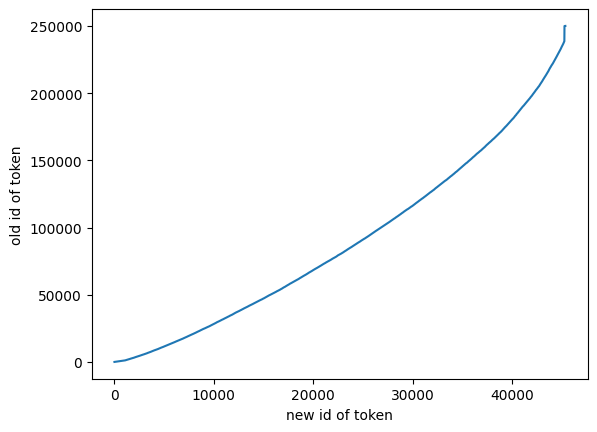

In [ ]:

import matplotlib.pyplot as plt
plt.plot(kept_ids)
plt.xlabel('new id of token')
plt.ylabel('old id of token')

update model embedding<br>
The new model has 90M parameters - 30% of the original size.<br>
(If only use top 10000 vocabs can reduce more, 45M params and 18% of original size)


In [ ]:

import torch

new_size = len(kept_ids)
new_emb = torch.nn.Embedding(new_size, model.shared.embedding_dim)
new_head = torch.nn.Linear(in_features=model.lm_head.in_features, out_features=new_size, bias=False)

for new_id, old_id in enumerate(kept_ids):
    new_emb.weight.data[new_id] = model.shared.weight.data[old_id]
    new_head.weight.data[new_id] = model.lm_head.weight.data[old_id]


model.shared.weight = new_emb.weight
model.lm_head.weight = new_head.weight


print("new model size compared to t5 model" , msize(model), msize(model) / original_size)


new model size compared to t5 model 90529152 0.30158613740554363


update tokenizer

In [ ]:

!wget https://raw.githubusercontent.com/google/sentencepiece/master/src/sentencepiece_model.proto
! protoc --python_out=. sentencepiece_model.proto

--2024-03-17 21:28:18--  https://raw.githubusercontent.com/google/sentencepiece/master/src/sentencepiece_model.proto
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14023 (14K) [text/plain]
Saving to: ‘sentencepiece_model.proto’

sentencepiece_model 100%[===================>]  13.69K  --.-KB/s    in 0.002s  

2024-03-17 21:28:18 (5.85 MB/s) - ‘sentencepiece_model.proto’ saved [14023/14023]



In [ ]:
import sentencepiece_model_pb2 as spmp
smp = tokenizer.sp_model.serialized_model_proto()
m = spmp.ModelProto()
m.ParseFromString(smp)

print('the loaded model has pieces:', len(m.pieces))
new_pieces = [m.pieces[idx] for idx in kept_ids]
print('the new pieces:', len(new_pieces))

# replace the content of the first 30K pieces
for i, p in enumerate(new_pieces):
    m.pieces[i].piece = p.piece
    m.pieces[i].score = p.score
    m.pieces[i].type = p.type

# drop the remaining pieces
n = len(new_pieces)
for i in trange(len(m.pieces) - n):
    m.pieces.pop(len(m.pieces) - 1)

print(len(m.pieces))
with open('new_sp.model', 'wb') as f:
    f.write(m.SerializeToString())

the loaded model has pieces: 250100
the new pieces: 45378


  0%|          | 0/204722 [00:00<?, ?it/s]

45378


save the new model

In [ ]:
new_tokenizer = T5Tokenizer('new_sp.model', extra_ids=0)

In [ ]:

model.config.__dict__['vocab_size'] = new_size
model.config.__dict__['_name_or_path'] = 'weny22/sum_model_t5'
model.config

T5Config {
  "_name_or_path": "weny22/sum_model_t5",
  "architectures": [
    "MT5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 1024,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "num_decoder_layers": 8,
  "num_heads": 6,
  "num_layers": 8,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "tie_word_embeddings": false,
  "tokenizer_class": "T5Tokenizer",
  "transformers_version": "4.38.2",
  "use_cache": true,
  "vocab_size": 45378
}

In [ ]:
## this is the original T5 model
print(model)

T5ForConditionalGeneration(
  (shared): Embedding(250112, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(250112, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
              (wo)

In [ ]:
new_tokenizer.save_pretrained('weny22/sum_model_t5')
model.save_pretrained('weny22/sum_model_t5')

load the new model


In [ ]:

model_new = T5ForConditionalGeneration.from_pretrained('weny22/sum_model_t5')
tokenizer_new = T5Tokenizer.from_pretrained('weny22/sum_model_t5')

In [ ]:
# model_new.push_to_hub("weny22/sum_model_t5_saved")

model.safetensors:   0%|          | 0.00/362M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/weny22/sum_model_t5_saved/commit/8b1001b59689acaae44c5136f86b304ad87423d5', commit_message='Upload T5ForConditionalGeneration', commit_description='', oid='8b1001b59689acaae44c5136f86b304ad87423d5', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
# tokenizer_new.push_to_hub("weny22/sum_model_t5_saved")

README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.00M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/weny22/sum_model_t5_saved/commit/257c38aa5c3895d98f80936a34edb97703abec99', commit_message='Upload tokenizer', commit_description='', oid='257c38aa5c3895d98f80936a34edb97703abec99', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
tokenizer_new.vocab_size

45378

In [ ]:
print(model_new) ## embedding and lm has been modified

T5ForConditionalGeneration(
  (shared): Embedding(45378, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(45378, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
              (wo): 

The part above saves a new model with a small size word embeddings, for future use, you can load the model by hugging face from my repo : "weny22/sum_model_t5_saved"<br>
tokenizer_new = T5Tokenizer.from_pretrained("weny22/sum_model_t5_saved")
model_new = T5ForConditionalGeneration.from_pretrained('weny22/sum_model_t5_saved')